In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
def cv2_imshow_plt(img):
    """
    Display RGB image loaded from cv2.imread()
    """
    if len(img.shape) == 3: # BGR
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    elif len(img.shape) == 2: # grayscale
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
    else:
        raise ValueError("sth is wrong")
    plt.axis('off')

In [6]:
#Face detection is done
#Labels for training data has been created

def labels_for_training_data(directory):
    faces = []
    faceID = []


    for path, subdirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename.startswith("."):
                print("skipping system file")
                continue
            id = os.path.basename(path)
            img_path = os.path.join(path, filename)
            print("img_path", img_path)
            print("id: ", id)
            img = cv2.imread(img_path)
            # img = cv2.resize(img, (231, 252))
            img = cv2.resize(img, (231, 313))
            img = cv2.GaussianBlur(img, (5,5),0)
            if img is None:
                print ("Not Loaded Properly")
                continue

            # faces_rect = img
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # if len(faces_rect)!=1:
            #     continue

            roi_gray = gray_img
            faces.append(roi_gray)
            faceID.append(int(id))

    return faces, faceID


#Here training Classifier is called
def train_classifier(faces, faceID):
    face_recognizer = cv2.face.LBPHFaceRecognizer_create()
    face_recognizer.train(faces, np.array(faceID))
    return face_recognizer

#Drawing a Rectangle on the Face Function
def draw_rect(test_img,face):
    x_start, y_start, x_end, y_end = face
    cv2.rectangle(test_img, (x_start, y_start), (x_end, y_end),(0, 255, 0), thickness=3)

#Putting text on images
def put_text(confidence, test_img, text, x, y):
    h2, w2 = test_img.shape[:2]
    cv2.putText(test_img, text, (x, y-5), cv2.FONT_HERSHEY_DUPLEX, (h2 + w2)/1000, (0, 0, 255), 5)
    cv2.putText(test_img, f"c = {confidence:.2f}", (20, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, (h2 + w2)/2000, (0, 0, 255), 5)


In [7]:
# Face detector
net = cv2.dnn.readNetFromCaffe("ssd/deploy.prototxt.txt", "ssd/res10_300x300_ssd_iter_140000.caffemodel")

def detect_faces_dnn(image):
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    faces = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.7:  # Confidence threshold
            box = detections[0, 0, i, 3:7] * [w, h, w, h]
            faces.append(box.astype("int"))
    return faces

face Detected:  [array([ 753,  795, 1682, 2281])]
skipping system file
img_path dataset_crop_test/0/hiepnm_4.jpg
id:  0
img_path dataset_crop_test/0/hiepnm_5.jpg
id:  0
img_path dataset_crop_test/0/hiepnm_1.jpg
id:  0
img_path dataset_crop_test/0/hiepnm_2.jpg
id:  0
img_path dataset_crop_test/0/hiepnm_3.jpg
id:  0
img_path dataset_crop_test/1/lamnt_1.jpg
id:  1
img_path dataset_crop_test/1/lamnt_2.jpg
id:  1
img_path dataset_crop_test/1/lamnt_3.jpg
id:  1
img_path dataset_crop_test/1/lamnt_4.jpg
id:  1
img_path dataset_crop_test/1/lamnt_5.jpg
id:  1
img_path dataset_crop_test/2/minhvb_4.jpg
id:  2
img_path dataset_crop_test/2/minhvb_5.jpg
id:  2
img_path dataset_crop_test/2/minhvb_1.jpg
id:  2
img_path dataset_crop_test/2/minhvb_2.jpg
id:  2
img_path dataset_crop_test/2/minhvb_3.jpg
id:  2
Confidence : 65.02063843660687
label : 2


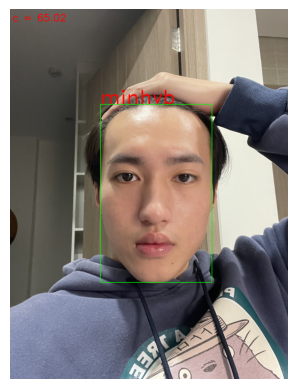

In [8]:
# folder = "augmented_dataset_crop_test/"
folder = "dataset_crop_test/"

# test_img = cv2.imread('test_img.jpeg')
# test_img = cv2.imread("augmented_dataset_crop_test/0/hiepnm_1.jpg")
# test_img = cv2.imread('test_img2.jpg')
test_img = cv2.imread('test_img3.jpg')

faces_detected = detect_faces_dnn(test_img)
gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
print("face Detected: ", faces_detected)

#Training will begin from here

faces, faceID = labels_for_training_data(folder) #Give path to the train-images folder which has both labeled folder as 0 and 1
face_recognizer = train_classifier(faces, faceID)
face_recognizer.save('models/trained_on_test.yml') #It will save the trained model. Just give path to where you want to save

name = {0: "hiepnm", 1: "lamnt", 2: "minhvb"}     #Change names accordingly. If you want to recognize only one person then write:- name={0:"name"} thats all. Dont write for id number 1.

for face in faces_detected:
    # if not face: print("Face not detected")
    x_start, y_start, x_end, y_end = face
    # box_height = y_end - y_start
    # y_start = y_start + int(0.2 * box_height)
    roi_gray = gray_img[y_start:y_end, x_start:x_end]
    roi_gray = cv2.resize(roi_gray, (231, 313))
    roi_gray = cv2.GaussianBlur(roi_gray, (5,5), 0)
    label, confidence = face_recognizer.predict(roi_gray)
    print ("Confidence :", confidence)
    print("label :", label)
    draw_rect(test_img, (x_start, y_start, x_end, y_end))
    predicted_name = name[label]
    put_text(confidence, test_img, predicted_name, x_start, y_start)

# resized_img = cv2.resize(test_img, (1000,700))

cv2_imshow_plt(test_img)

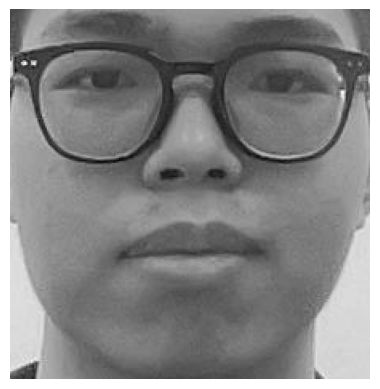

In [12]:
cv2_imshow_plt(gray_img)

In [8]:
# faces, faceID = labels_for_training_data(folder)
print(faceID)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]


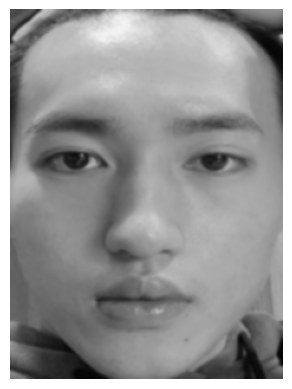

In [9]:
cv2_imshow_plt(roi_gray)

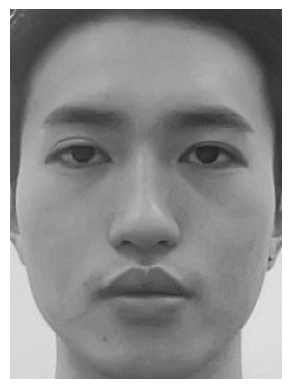

In [50]:
cv2_imshow_plt(faces[12])

In [10]:
h, w = roi_gray.shape[:2]
h, w

(313, 231)

In [11]:
# ALL THIS IS TO FIND THE AVERAGE H & W OUR CROPPED FACE DATA

def labels_for_training_data(directory):
    faces = []
    faceID = []

    for path, subdirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename.startswith("."):
                print("Skipping system file:", filename)
                continue
            id = os.path.basename(path)
            img_path = os.path.join(path, filename)
            print("Loading image:", img_path)
            print("ID:", id)
            
            img = cv2.imread(img_path)
            if img is None:
                print("Image not loaded properly:", img_path)
                continue

            # img = cv2.resize(img, (1000, 1000))  # Resize for consistency

            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces.append(gray_img)
            faceID.append(int(id))

    return faces, faceID


def calculate_average_size(faces):
    total_width = 0
    total_height = 0
    num_faces = len(faces)

    if num_faces == 0:
        print("No faces found.")
        return None

    for face in faces:
        height, width = face.shape
        total_width += width
        total_height += height

    avg_width = total_width / num_faces
    avg_height = total_height / num_faces

    print(f"\nAverage Width: {avg_width:.2f} pixels")
    print(f"Average Height: {avg_height:.2f} pixels")
    print(f"Average Aspect Ratio (Width:Height): {avg_width / avg_height:.2f}")

    return avg_width, avg_height


# Path to your dataset
directory = "dataset_crop_test"

# Load faces and IDs
faces, faceID = labels_for_training_data(directory)

# Calculate average size
calculate_average_size(faces)


Skipping system file: .DS_Store
Loading image: dataset_crop_test/0/hiepnm_4.jpg
ID: 0
Loading image: dataset_crop_test/0/hiepnm_5.jpg
ID: 0
Loading image: dataset_crop_test/0/hiepnm_1.jpg
ID: 0
Loading image: dataset_crop_test/0/hiepnm_2.jpg
ID: 0
Loading image: dataset_crop_test/0/hiepnm_3.jpg
ID: 0
Loading image: dataset_crop_test/1/lamnt_1.jpg
ID: 1
Loading image: dataset_crop_test/1/lamnt_2.jpg
ID: 1
Loading image: dataset_crop_test/1/lamnt_3.jpg
ID: 1
Loading image: dataset_crop_test/1/lamnt_4.jpg
ID: 1
Loading image: dataset_crop_test/1/lamnt_5.jpg
ID: 1
Loading image: dataset_crop_test/2/minhvb_4.jpg
ID: 2
Loading image: dataset_crop_test/2/minhvb_5.jpg
ID: 2
Loading image: dataset_crop_test/2/minhvb_1.jpg
ID: 2
Loading image: dataset_crop_test/2/minhvb_2.jpg
ID: 2
Loading image: dataset_crop_test/2/minhvb_3.jpg
ID: 2

Average Width: 231.20 pixels
Average Height: 313.67 pixels
Average Aspect Ratio (Width:Height): 0.74


(231.2, 313.6666666666667)